In [ ]:
%load_ext autoreload
%autoreload 2


In [ ]:
import numpy as np
import crocoddyl
import torch
from finite_differences import a2m, m2a, FeedForwardTerminal, SQTerminal, HessianTerminal
from utils import griddata, circular

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
fnet = torch.load("fnet.pth")
sqnet = torch.load('sqnet.pth')


In [ ]:
xtest = circular()
print(xtest.shape)

In [8]:
regular_cost  = []
regular_iters = []
regular_traj  = []

#ffn_cost  = []
#ffn_iters = []
#ffn_traj  = []

sqn_cost  = []
sqn_iters = []
sqn_traj  = []

for xyz in xtest:
    # Regular
    model = crocoddyl.ActionModelUnicycle()
    T = 30
    model.costWeights = np.matrix([1,1]).T
    problem = crocoddyl.ShootingProblem(m2a(xyz).T, [ model ] * T, model)
    ddp = crocoddyl.SolverFDDP(problem)
    ddp.solve([], [], 1000)
    regular_cost.append(ddp.cost)
    regular_iters.append(ddp.iter)
    xs_ = np.array(ddp.xs)
    xs = xs_[:,0:2]
    regular_traj.append(xs)


    # FeedForward
    #model2 = crocoddyl.ActionModelUnicycle()
    #ffn_model = FeedForwardTerminal(fnet)
    #model2.costWeights = np.matrix([1,1]).T
    #problem2 = crocoddyl.ShootingProblem(m2a(xyz).T, [ model2 ] * T, ffn_model)
    #ddp2 = crocoddyl.SolverDDP(problem2)
    #ddp2.solve([], [], 1000)
    #ffn_cost.append(ddp2.cost)
    #ffn_iters.append(ddp2.iter)
    #xs2_ = np.array(ddp2.xs)
    #xs2 = xs2_[:,0:2]
    #ffn_traj.append(xs2)
    
    # SQN
    model3 = crocoddyl.ActionModelUnicycle()
    sqn_model = HessianTerminal(sqnet)
    model3.costWeights = np.matrix([1,1]).T
    problem3 = crocoddyl.ShootingProblem(m2a(xyz).T, [ model3 ] * T, sqn_model)
    ddp3 = crocoddyl.SolverFDDP(problem3)
    ddp3.solve([], [], 1000)
    sqn_cost.append(ddp3.cost)
    sqn_iters.append(ddp3.iter)
    xs3_ = np.array(ddp3.xs)
    xs3 = xs3_[:,0:2]
    sqn_traj.append(xs3)
    
    

In [9]:

def plot_trajectories(cost, trajectories, name = "Cost", savename=None, title=None ):
    """
    
    @params:
        cost           = list of keys for cmap
        trajectories   = list of corresponding trajectories
        name           = str, to distinguish between cost and iterations
        
    @ returns plot of trajectories colored according to keys.    
    
    """

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    mpl.rcParams['figure.dpi'] = 80
    fig = plt.figure(figsize=(8, 6))

    norm = mpl.colors.Normalize(vmin=min(cost), vmax=max(cost))
    cmap = mpl.cm.ScalarMappable(norm = norm, cmap=mpl.cm.plasma)
    cmap.set_array([])


    for key, trajectory in zip(cost, trajectories):
        plt.scatter(trajectory[:, 0], trajectory[:, 1], 
                    marker = '',
                    zorder=2, 
                    s=50,
                    linewidths=0.2,
                    alpha=.8, 
                    cmap = cmap )
        plt.plot(trajectory[:, 0], trajectory[:, 1], c=cmap.to_rgba(key))

    plt.xlabel("X Coordinates", fontsize = 20)
    plt.ylabel("Y Coordinates", fontsize = 20)
    if title:
        plt.title(title)
    plt.colorbar(cmap).set_label(name, labelpad=2, size=15)
    if savename is not None:
        plt.savefig("./images/"+savename+".png")
    plt.show()

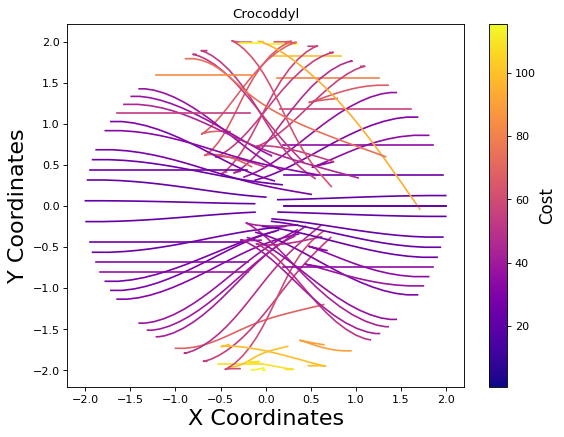

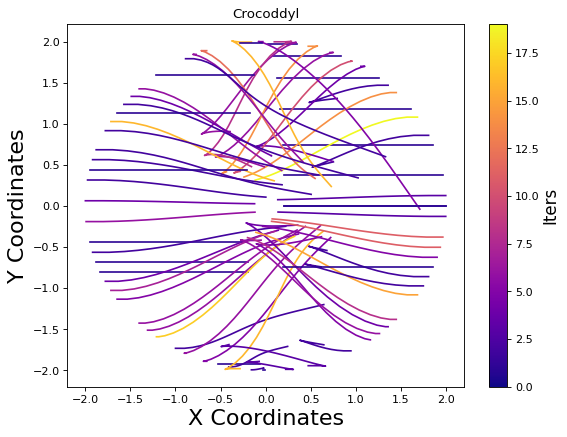

In [10]:
plot_trajectories(sqn_cost, sqn_traj, name = "Cost", title= "Crocoddyl")
plot_trajectories(sqn_iters, sqn_traj, name = "Iters", title= "Crocoddyl")